# ccs-subread-align Demo

This notebook demonstrates the full pipeline: loading PacBio data, aligning subreads to CCS reads, calculating base composition, and sanity-checking the results with plots.

In [1]:
import numpy as np
import pandas as pd
import pysam
import matplotlib.pyplot as plt
from pathlib import Path

from ccs_subread_align import (
    load_reference,
    load_ccs_reads,
    load_subreads,
    process_subread_alignment,
    calculate_all_base_compositions,
)

In [2]:
DATA_DIR = Path("../tests/data")
REF_FASTA = DATA_DIR / "hg38_chrM_circularized_by_doubling.fa"
CCS_BAM = DATA_DIR / "test_cases.bam"
SUBREADS_BAM = DATA_DIR / "test_cases_subreads.bam"
CHRM_LENGTH = 16569

In [3]:
# Load reference and extract ZMW list from CCS BAM
ref_seqs = load_reference(str(REF_FASTA))

zmws = set()
with pysam.AlignmentFile(str(CCS_BAM), "rb") as bam:
    for read in bam.fetch():
        parts = read.query_name.split("/")
        if len(parts) >= 2:
            try:
                zmws.add(int(parts[1]))
            except ValueError:
                pass
zmw_list = sorted(zmws)

ccs_reads = load_ccs_reads(str(CCS_BAM), zmw_list, CHRM_LENGTH)
subreads_by_zmw = load_subreads(str(SUBREADS_BAM), zmw_list)
zmw_to_chrom = {ccs["zmw"]: ccs["reference_name"] for ccs in ccs_reads}

print(f"{len(ccs_reads)} CCS reads, {sum(len(v) for v in subreads_by_zmw.values())} subreads")

50 CCS reads, 627 subreads


In [4]:
# Align subreads to CCS reads
assigned = process_subread_alignment(
    zmw_list, subreads_by_zmw, ref_seqs, zmw_to_chrom,
    CHRM_LENGTH, min_identity=0.5, n_cores=4
)
print(f"{len(assigned)} subreads assigned")

Assigning subreads (4 cores): 100%|████████████████████████████████████████████████████████████████████████████| 627/627 [00:16<00:00, 37.10it/s]

626 subreads assigned


In [5]:
# Calculate base composition
df = calculate_all_base_compositions(
    ccs_reads, assigned, ref_seqs, zmw_to_chrom, CHRM_LENGTH, n_cores=4
)
print(f"{len(df):,} positions")
df

Processing CCS reads (4 cores): 100%|████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.72it/s]

574,723 positions


,zmw,strand,zmw_strand,ccs_pos,ref_pos,ccs_base,q_score,A_count,T_count,C_count,G_count,N_count,total_subreads,agreement_fraction,reference_base
0,25037523,fwd,25037523_fwd,0,3665,G,53,0,0,0,7,0,7,1.00,G
1,25037523,fwd,25037523_fwd,1,3666,T,77,0,7,0,0,0,7,1.00,T
2,25037523,fwd,25037523_fwd,2,3667,G,37,0,0,0,7,0,7,1.00,G
3,25037523,fwd,25037523_fwd,3,3668,A,59,7,0,0,0,0,7,1.00,A
4,25037523,fwd,25037523_fwd,4,3669,G,21,0,0,0,6,0,6,1.00,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574718,99485149,fwd,99485149_fwd,3255,14258,G,93,3,2,0,15,0,20,0.75,G
574719,99485149,fwd,99485149_fwd,3256,14259,A,93,29,0,0,0,0,29,1.00,A
574720,99485149,fwd,99485149_fwd,3257,14260,T,93,0,24,0,0,0,24,1.00,T
574721,99485149,fwd,99485149_fwd,3258,14261,C,93,0,0,22,0,0,22,1.00,C


### Q-score vs subread agreement fraction

PacBio CCS Q-scores are derived from a log-likelihood model that incorporates subread agreement along with other signal features. We therefore expect agreement fraction to follow a rough logarithmic trend with Q-score, though the fit will be noisy — especially with few ZMWs — because Q-scores capture more than pure subread consensus.

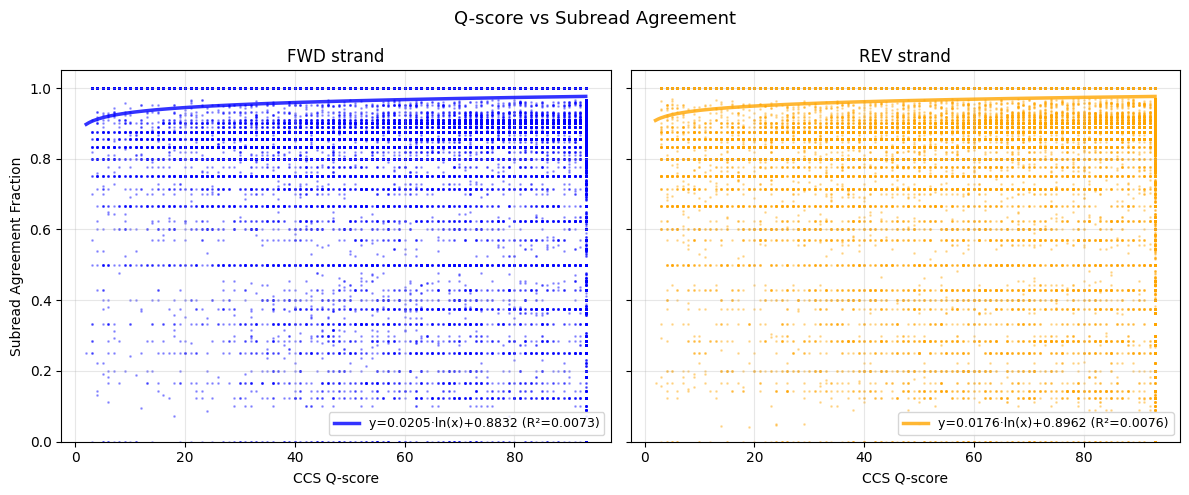

In [6]:
# Plot 1: Q-score vs subread agreement fraction (separate panels per strand)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, (strand, color) in zip(axes, [("fwd", "blue"), ("rev", "orange")]):
    data = df[df["strand"] == strand]
    valid = data[(data["q_score"] > 0) & (data["total_subreads"] > 0)].copy()

    ax.scatter(valid["q_score"], valid["agreement_fraction"],
               alpha=0.3, s=1, color=color, rasterized=True)

    if len(valid) > 10:
        log_q = np.log(valid["q_score"].values.astype(np.float64))
        agree = valid["agreement_fraction"].values.astype(np.float64)
        coeffs = np.polyfit(log_q, agree, 1)  # y = a*ln(x) + b
        a, b = coeffs
        q_range = np.linspace(valid["q_score"].min(), valid["q_score"].max(), 200)
        y_fit = a * np.log(q_range) + b
        y_pred = a * log_q + b
        ss_res = np.sum((agree - y_pred) ** 2)
        ss_tot = np.sum((agree - agree.mean()) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0
        ax.plot(q_range, y_fit, color=color, linewidth=2.5, alpha=0.8,
                label=f"y={a:.4f}·ln(x)+{b:.4f} (R²={r2:.4f})")
        ax.legend(fontsize=9, loc="lower right")

    ax.set_xlabel("CCS Q-score")
    ax.set_ylim(0, 1.05)
    ax.set_title(f"{strand.upper()} strand")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Subread Agreement Fraction")
fig.suptitle("Q-score vs Subread Agreement", fontsize=13)
plt.tight_layout()
plt.show()

### Forward vs reverse strand assignment

Each subread is aligned to the reference in both orientations and assigned to the strand with the better alignment. Since subreads are generated without strand bias, we expect roughly equal counts for forward and reverse.

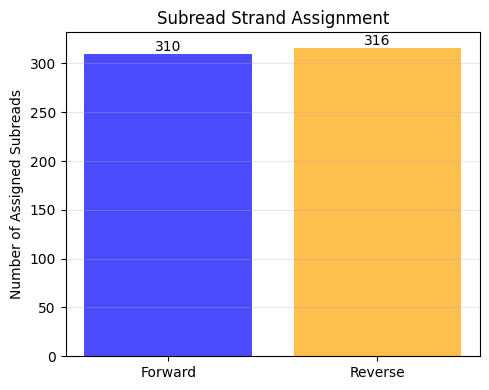

fwd=310, rev=316, ratio=0.98


In [7]:
# Plot 2: Forward vs reverse subread assignment counts
strand_counts = pd.Series([s["strand"] for s in assigned]).value_counts()
fwd_count = strand_counts.get("fwd", 0)
rev_count = strand_counts.get("rev", 0)

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(["Forward", "Reverse"], [fwd_count, rev_count], color=["blue", "orange"], alpha=0.7)
ax.bar_label(bars)
ax.set_ylabel("Number of Assigned Subreads")
ax.set_title("Subread Strand Assignment")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(f"fwd={fwd_count}, rev={rev_count}, ratio={fwd_count/rev_count:.2f}" if rev_count > 0 else f"fwd={fwd_count}, rev=0")